# Import

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil

In [2]:
import windows_utils_hf as util
import helpers

In [3]:
from sklearn import model_selection, metrics

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from PIL import Image
import re
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor

# Import HuggingFace Datasets dependencies
from datasets import load_dataset

from torchvision.transforms import v2
from torchvision.io import read_image

# Load Data

In [5]:
repo_fp = Path('../data/')
noh_fp = repo_fp / 'NOH'

## NOH Data

In [6]:
noh_data = pd.read_csv('../metadata/NOH_opt1_3c.csv', index_col=0)
noh_data

,Patient #,FNA biopsy,Surgery diagnosis,Bethesda,Bethesda_num,label,fold_0,fold_1,fold_2,fold_3,fold_4,patient_id,image_path,new_label
0,1,Thyroid papillary carcinoma (Bethesda V),Thyroid papillary carcinoma,V,5,4,test,train,train,train,test,1,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2
1,1,Thyroid papillary carcinoma (Bethesda V),Thyroid papillary carcinoma,V,5,4,test,train,train,train,test,1,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2
2,1,Thyroid papillary carcinoma (Bethesda V),Thyroid papillary carcinoma,V,5,4,test,train,train,train,test,1,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2
3,1,Thyroid papillary carcinoma (Bethesda V),Thyroid papillary carcinoma,V,5,4,test,train,train,train,test,1,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2
4,1,Thyroid papillary carcinoma (Bethesda V),Thyroid papillary carcinoma,V,5,4,test,train,train,train,test,1,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,132,Thyroid papillary carcinoma (Bethesda VI),Thyroid papillary carcinoma,VI,6,5,test,test,train,test,train,132,../data/NOH/132. LTN/IMG_20230228_134752.jpg,2
2044,132,Thyroid papillary carcinoma (Bethesda VI),Thyroid papillary carcinoma,VI,6,5,test,test,train,test,train,132,../data/NOH/132. LTN/IMG_20230228_134749.jpg,2
2045,132,Thyroid papillary carcinoma (Bethesda VI),Thyroid papillary carcinoma,VI,6,5,test,test,train,test,train,132,../data/NOH/132. LTN/IMG_20230228_134822.jpg,2
2046,132,Thyroid papillary carcinoma (Bethesda VI),Thyroid papillary carcinoma,VI,6,5,test,test,train,test,train,132,../data/NOH/132. LTN/IMG_20230228_134601.jpg,2


In [7]:
noh_data['new_label'].value_counts().sort_index()

new_label
0      97
1     374
2    1577
Name: count, dtype: int64

In [8]:
noh_data[['patient_id', 'new_label']].drop_duplicates()['new_label'].value_counts().sort_index()

new_label
0      6
1     26
2    100
Name: count, dtype: int64

In [9]:
foldk = 'fold_2'

# Stats

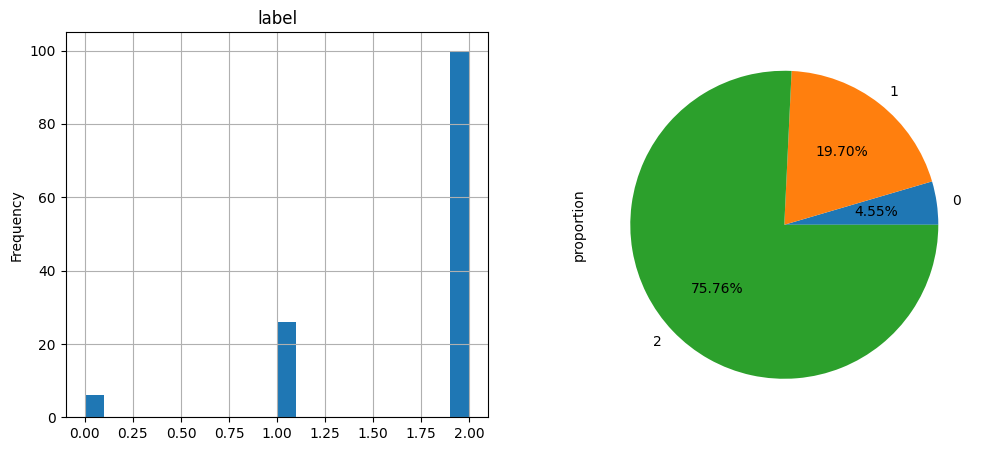

In [10]:
noh_sum = noh_data[['patient_id', 'new_label']].drop_duplicates()
fig, axs = plt.subplots(1,2,figsize=(12,5))
noh_sum['new_label'].plot(kind='hist', bins=20, title='label',ax=axs[0], grid=True)
noh_sum['new_label'].value_counts(dropna=False, normalize=True).fillna('NA').sort_index().plot(kind='pie', autopct='%.2f%%', ax=axs[1])
plt.gca().spines[['top', 'right',]].set_visible(False)

## Per patient

In [11]:
noh_data.groupby([foldk,'new_label'])['patient_id'].nunique().to_frame().reset_index().pivot_table(index=foldk, columns='new_label', values='patient_id').astype(int)

new_label,0,1,2
fold_2,,,
test,2,8,30
train,4,18,70


## Per Image

In [12]:
noh_data.groupby([foldk,'new_label'])['image_path'].nunique().to_frame().reset_index().pivot_table(index=foldk, columns='new_label', values='image_path').astype(int)

new_label,0,1,2
fold_2,,,
test,31,131,469
train,66,243,1108


In [13]:
img_ds = noh_data[['image_path', 'new_label', foldk]]
img_ds

,image_path,new_label,fold_2
0,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2,train
1,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2,train
2,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2,train
3,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2,train
4,../data/NOH/001.NguyeThiLan- Right/IMG_2022121...,2,train
...,...,...,...
2043,../data/NOH/132. LTN/IMG_20230228_134752.jpg,2,train
2044,../data/NOH/132. LTN/IMG_20230228_134749.jpg,2,train
2045,../data/NOH/132. LTN/IMG_20230228_134822.jpg,2,train
2046,../data/NOH/132. LTN/IMG_20230228_134601.jpg,2,train


## Transform

In [14]:
plt.rcParams["savefig.bbox"] = 'tight'

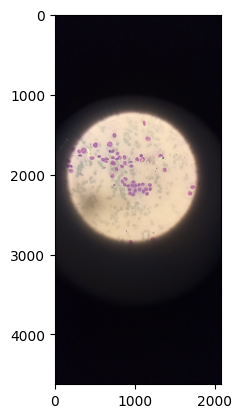

In [15]:
img_path = img_ds.iloc[0]['image_path']
# img = read_image(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [16]:
# prompt: generate train and test transform


# Create transforms for train and test data
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.RandomCrop(224),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10), # [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.CenterCrop(size=224),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Inspect train and test transform

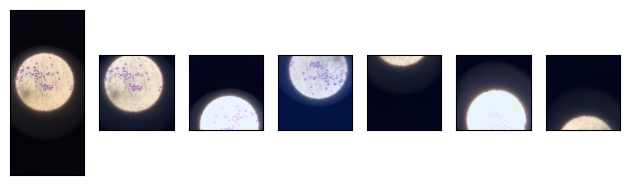

In [17]:
train_outs = [train_transform(img) for i in range(5)]
test_out = test_transform(img)
helpers.plot([img, test_out] + train_outs)

## Batch size

In [18]:
batch_size=16

# Dataset and DataLoader

In [19]:
# prompt: i need pytorch dataset that read from dataframe
class NOHThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['image_path'][idx]
        label = self.dataframe['new_label'][idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [20]:
train_df = img_ds[img_ds[foldk]=='train'].reset_index(drop=True)
# val_df = img_ds[img_ds['dataset']=='val'].reset_index(drop=True)
test_df = img_ds[img_ds[foldk]=='test'].reset_index(drop=True)

In [21]:
trainset = NOHThyroidDataset(train_df, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [22]:
# valset = NOHThyroidDataset(val_df, transform=test_transform)
# valoader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
#                                           shuffle=False, num_workers=8)

In [23]:
testset = NOHThyroidDataset(test_df, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

##  Inspect Image

In [24]:
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

../data/NOH/121. LVT/IMG_20230228_080942.jpg


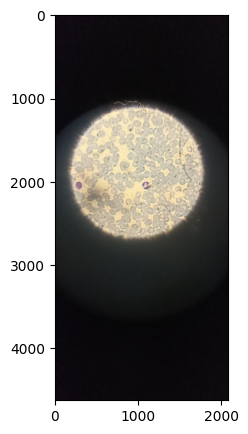

In [25]:
# Select a random item from the dataset
import numpy as np
item_path = np.random.choice(train_df['image_path'])
print(item_path)
sample_img = Image.open(item_path)
# Display the image
fig = plt.figure(figsize=(10,5))
plt.imshow(sample_img)
plt.show()

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


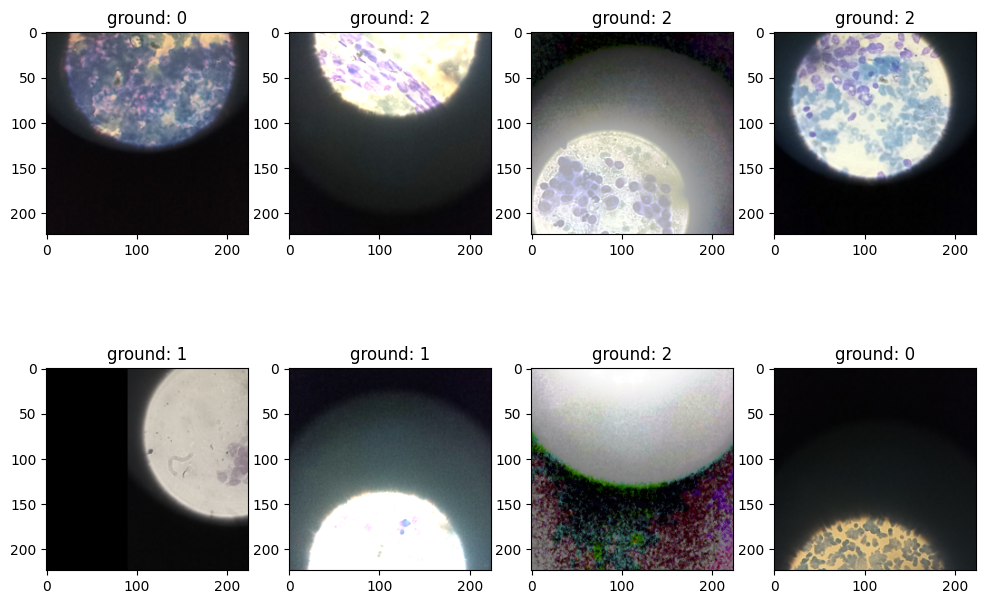

In [26]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 4, figsize=(12, 8))
for r in range(0, 2):
  for c in range(0, 4):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img, *norm_stats)))
    axarr[r, c].set_title(f'ground: {label}')
    indx+=1
#tensor_to_pil(denorm_img_tensor(train_dataset[10][0], *norm_stats))

## Device and Tensorboard

In [27]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of available GPUs: {num_gpus}")

    # List information about each GPU
    for i in range(num_gpus):
        gpu_info = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_info.name}")
        print(f"   Compute Capability: {gpu_info.major}.{gpu_info.minor}")
        print(f"   Total Memory: {gpu_info.total_memory / (1024 ** 3):.2f} GB\n")
else:
    print("No GPUs available.")


Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB

GPU 1: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB



In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [29]:
# prompt: use tensorboard to log
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('../runs/thyroid_NOH_opt1_3c')

2024-03-12 20:57:31.499153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 20:57:31.499190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 20:57:31.500312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 20:57:31.506467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 20:57:32.404254: W tensorflow/comp

# Load model

In [30]:
# prompt: train this trainloader using efficient-net model. this is classification problem
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [31]:
model._fc = nn.Linear(model._fc.in_features, train_df['new_label'].nunique())
model.to(device);

In [32]:
model._fc

Linear(in_features=1280, out_features=3, bias=True)

In [33]:
num_epochs = 100
best_val_acc = 0.0

# Criterion, Optimizer, Scheduler

In [34]:
import torch
import torch.nn.functional as F

def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = -1,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """
    inputs = inputs.float()
    targets = targets.float()
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

In [36]:
# AdamW optimizer; includes weight decay for regularization
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=num_epochs*len(trainloader))

In [37]:
def report_clf(preds_ts, outs_ts):
    np_preds = [i.numpy() for i in preds_ts]
    np_outs = [i.numpy() for i in outs_ts]
    
    np_preds = np.array([i for s in np_preds for i in s])
    np_outs = np.array([i for s in np_outs for i in s])
    assert np_preds.shape == np_outs.shape

    print(metrics.classification_report(np_outs, np_preds))

    cm = metrics.confusion_matrix(np_outs, np_preds)
    d = metrics.ConfusionMatrixDisplay(cm)
    d.plot()
    plt.show()

In [38]:
def evaluate_dataset(model, ds_loader):
    model.eval()
    loss = 0.0
    acc = 0.0
    preds = []
    outs = []
    for _, (data, target) in enumerate(tqdm(ds_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss += loss.item()
        acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
        preds.append(output.cpu().argmax(dim=1))
        outs.append(target.cpu())
        
    loss /= len(testloader)
    acc /= len(testloader)
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(loss, acc))
    report_clf(preds, outs)
    return acc,preds, outs

# If exist model, then evaluate before write new

In [39]:
def run_predict_testset():
    test_features, test_labels = next(iter(testloader))
    # Make a prediction with the model
    class_names = [0,1,2]
    with torch.no_grad():
        preds = model(test_features.to(device))
        #print(preds)
        print(f"Feature batch shape: {test_features.size()}")
        print(f"Labels batch shape: {test_labels.size()}")
        indx = 0
        f, axarr = plt.subplots(3, 3, figsize=(12, 8))
        for r in range(0, 3):
            for c in range(0, 3):
                img_tensor = test_features[indx]
                label = class_names[test_labels[indx].numpy()]
                print('Label: ', label)
                # Scale the model predictions to add up to 1
                pred_scores = torch.softmax(preds[indx], dim=0)
                # Get the highest confidence score
                confidence_score = pred_scores.max()
                # Get the class index with the highest confidence score and convert it to the class name
                pred_class = class_names[torch.argmax(pred_scores)]
                print('Predicted: ', pred_class)
                axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img_tensor, *norm_stats)))
                axarr[r, c].set_title(f"ground: {label}, pred: {pred_class}, conf: {confidence_score*100:.2f}%")
                indx+=1
        plt.tight_layout()
        plt.show()

In [40]:
baseline_model_path = '../model/noh_opt1_3c/efficientnet-b0-clf.pt'

  0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.0071 	Test Acc: 0.8417
              precision    recall  f1-score   support

           0       0.45      0.71      0.55        31
           1       0.83      0.37      0.51       131
           2       0.88      0.98      0.93       469

    accuracy                           0.84       631
   macro avg       0.72      0.69      0.66       631
weighted avg       0.85      0.84      0.82       631



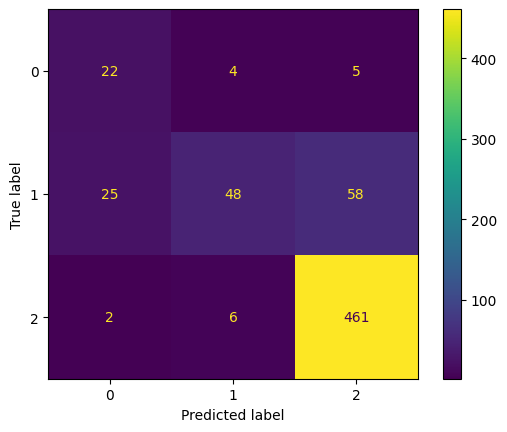

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])
Label:  1
Predicted:  2
Label:  1
Predicted:  0
Label:  1
Predicted:  0
Label:  1
Predicted:  1
Label:  1
Predicted:  0
Label:  1
Predicted:  0
Label:  1
Predicted:  2
Label:  1
Predicted:  0
Label:  1
Predicted:  0


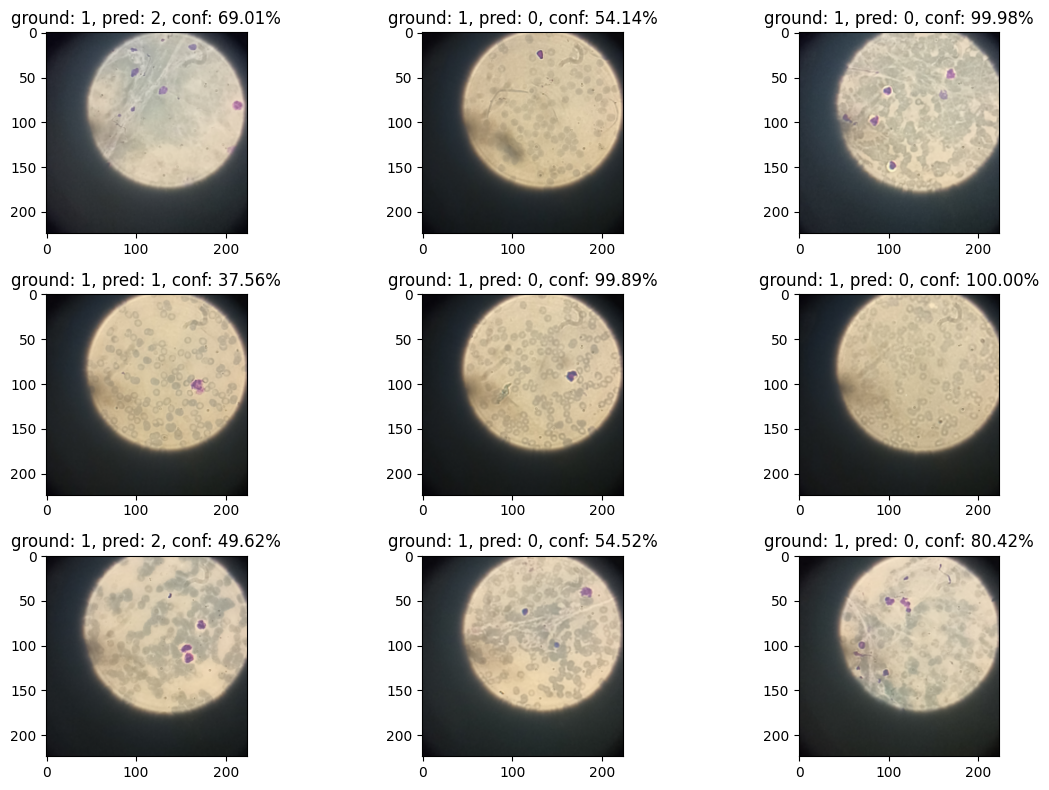

In [41]:
# reload model
model_fp = Path(baseline_model_path)
if model_fp.exists():
    model.load_state_dict(torch.load(str(model_fp), map_location=torch.device(device)))
    best_val_acc, _, _ = evaluate_dataset(model, testloader)
    run_predict_testset()

In [42]:
best_val_acc

0.8417410714285714

# Train model

In [43]:
# for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#     data, target = data.to(device), target.to(device)

In [44]:
# for batch_idx, (data, target) in enumerate(tqdm(valoader)):
#     data, target = data.to(device), target.to(device)

In [45]:
# for batch_idx, (data, target) in enumerate(tqdm(testloader)):
#     data, target = data.to(device), target.to(device)

In [46]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(testloader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        val_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    val_loss /= len(testloader)
    val_acc /= len(testloader)

    scheduler.step(val_loss)

    print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(
        epoch, train_loss, train_acc, val_loss, val_acc))
    writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Validation/Loss', val_loss, epoch * len(testloader) + batch_idx)
    writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(testloader) + batch_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f'Better result, val: {best_val_acc}')
        torch.save(model.state_dict(), baseline_model_path)
        evaluate_dataset(model, testloader)

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0 	Train Loss: 0.4046 	Train Acc: 0.8485 	Val Loss: 0.7923 	Val Acc: 0.7781


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 	Train Loss: 0.4101 	Train Acc: 0.8429 	Val Loss: 0.5831 	Val Acc: 0.8000


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [02:40<?, ?it/s]

Epoch: 2 	Train Loss: 0.4082 	Train Acc: 0.8444 	Val Loss: 0.9520 	Val Acc: 0.8094


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3 	Train Loss: 0.3943 	Train Acc: 0.8541 	Val Loss: 0.5618 	Val Acc: 0.7656


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4 	Train Loss: 0.3599 	Train Acc: 0.8662 	Val Loss: 0.8256 	Val Acc: 0.6875


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [03:20<?, ?it/s]

Epoch: 5 	Train Loss: 0.3580 	Train Acc: 0.8639 	Val Loss: 0.5513 	Val Acc: 0.8203


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6 	Train Loss: 0.3577 	Train Acc: 0.8695 	Val Loss: 0.5476 	Val Acc: 0.8172


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7 	Train Loss: 0.3439 	Train Acc: 0.8722 	Val Loss: 0.7269 	Val Acc: 0.7891


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8 	Train Loss: 0.3315 	Train Acc: 0.8701 	Val Loss: 0.7863 	Val Acc: 0.8281


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9 	Train Loss: 0.3290 	Train Acc: 0.8750 	Val Loss: 0.6407 	Val Acc: 0.7683


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 3.0000e-04.
Epoch: 10 	Train Loss: 0.3475 	Train Acc: 0.8730 	Val Loss: 0.5753 	Val Acc: 0.8078


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11 	Train Loss: 0.2790 	Train Acc: 0.8873 	Val Loss: 0.5072 	Val Acc: 0.8219


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12 	Train Loss: 0.3092 	Train Acc: 0.8780 	Val Loss: 0.5571 	Val Acc: 0.7859


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13 	Train Loss: 0.2551 	Train Acc: 0.9108 	Val Loss: 0.6014 	Val Acc: 0.7922


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14 	Train Loss: 0.2484 	Train Acc: 0.9108 	Val Loss: 0.5944 	Val Acc: 0.8000


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 9.0000e-05.
Epoch: 15 	Train Loss: 0.2221 	Train Acc: 0.9194 	Val Loss: 0.7924 	Val Acc: 0.7344


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16 	Train Loss: 0.2428 	Train Acc: 0.9111 	Val Loss: 0.7020 	Val Acc: 0.7641


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17 	Train Loss: 0.2337 	Train Acc: 0.9073 	Val Loss: 0.6601 	Val Acc: 0.8000


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [03:20<?, ?it/s]

Epoch: 18 	Train Loss: 0.2174 	Train Acc: 0.9146 	Val Loss: 0.6888 	Val Acc: 0.7891


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 00020: reducing learning rate of group 0 to 2.7000e-05.
Epoch: 19 	Train Loss: 0.2150 	Train Acc: 0.9185 	Val Loss: 0.6847 	Val Acc: 0.8000


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20 	Train Loss: 0.2069 	Train Acc: 0.9249 	Val Loss: 0.6917 	Val Acc: 0.8031


  0%|          | 0/89 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 21 	Train Loss: 0.2071 	Train Acc: 0.9213 	Val Loss: 0.7062 	Val Acc: 0.7844


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 22 	Train Loss: 0.1973 	Train Acc: 0.9285 	Val Loss: 0.7171 	Val Acc: 0.7969


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 00024: reducing learning rate of group 0 to 8.1000e-06.
Epoch: 23 	Train Loss: 0.2063 	Train Acc: 0.9157 	Val Loss: 0.7206 	Val Acc: 0.7969


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

  0%|          | 0/89 [00:17<?, ?it/s]

^^^^ ^^  ^  ^^^
^^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^ ^^ 
    File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
        ^  ^^ ^  ^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^AssertionError: ^^can only test a child process
^^^
Exception ignored in: AssertionError: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>can only test a child process
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if 

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 24 	Train Loss: 0.2075 	Train Acc: 0.9298 	Val Loss: 0.7286 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 25 	Train Loss: 0.2013 	Train Acc: 0.9264 	Val Loss: 0.7361 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

  0%|          | 0/40 [00:00<?, ?it/s]

  ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only

Epoch: 26 	Train Loss: 0.1914 	Train Acc: 0.9278 	Val Loss: 0.7390 	Val Acc: 0.7937


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 00028: reducing learning rate of group 0 to 2.4300e-06.
Epoch: 27 	Train Loss: 0.2006 	Train Acc: 0.9312 	Val Loss: 0.7356 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 28 	Train Loss: 0.1813 	Train Acc: 0.9371 	Val Loss: 0.7464 	Val Acc: 0.7969


  0%|          | 0/89 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>Traceback (most recent call last):

  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
            ^ ^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 29 	Train Loss: 0.1980 	Train Acc: 0.9221 	Val Loss: 0.7450 	Val Acc: 0.7937


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 30 	Train Loss: 0.1873 	Train Acc: 0.9336 	Val Loss: 0.7426 	Val Acc: 0.7906


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 00032: reducing learning rate of group 0 to 7.2900e-07.
Epoch: 31 	Train Loss: 0.2090 	Train Acc: 0.9277 	Val Loss: 0.7505 	Val Acc: 0.7953


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

Traceback (most recent call last):
      File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():    
self._shutdown_workers() 
   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      if w.is_alive(): 
   ^ ^ ^ ^^ ^  ^^^^^^^^^^^^^
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", 

  0%|          | 0/89 [00:01<?, ?it/s]

^ ^^
 ^^^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
 self._shutdown_workers()
   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    
      File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():^     Exception ignored in: 
assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>^if w.is_alive():
 
  ^
  Traceback (most recent call last):
   ^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    ^       self._shutdown_workers() ^ 
  ^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  ^^      ^if w.

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 32 	Train Loss: 0.1881 	Train Acc: 0.9326 	Val Loss: 0.7506 	Val Acc: 0.7937


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 33 	Train Loss: 0.1957 	Train Acc: 0.9250 	Val Loss: 0.7467 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 34 	Train Loss: 0.1925 	Train Acc: 0.9256 	Val Loss: 0.7438 	Val Acc: 0.7984


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 00036: reducing learning rate of group 0 to 2.1870e-07.
Epoch: 35 	Train Loss: 0.1928 	Train Acc: 0.9280 	Val Loss: 0.7496 	Val Acc: 0.7969


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 36 	Train Loss: 0.1989 	Train Acc: 0.9315 	Val Loss: 0.7508 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>Traceback (most recent call last):

  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    self._shutdown_workers()
Exception ignored in:   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
if w.is_alive():
 
Traceback (most recent call las

  0%|          | 0/40 [03:20<?, ?it/s]

Epoch: 37 	Train Loss: 0.2093 	Train Acc: 0.9185 	Val Loss: 0.7537 	Val Acc: 0.7969


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 38 	Train Loss: 0.1949 	Train Acc: 0.9256 	Val Loss: 0.7482 	Val Acc: 0.7969


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 00040: reducing learning rate of group 0 to 6.5610e-08.
Epoch: 39 	Train Loss: 0.2027 	Train Acc: 0.9249 	Val Loss: 0.7541 	Val Acc: 0.7937


  0%|          | 0/89 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>Exception ignored in: 
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
    Traceback (most recent call last):
self._shutdown_workers()  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Exception ignored in: self._shutdown_workers()  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>    
if w.is_alive():
 
Traceback (most recent call las

  0%|          | 0/40 [01:53<?, ?it/s]

 

^^ ^^   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^ ^^ ^        ^^^  ^assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():^^^  ^

^^  ^ 
 ^^^  ^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
 ^^^^ ^^     ^^^ ^assert self._parent_pid == os.getpid(), 'can only test a child process'^ ^^^ ^
^ ^^ ^
^  ^^   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^  ^^^    ^^ ^^ ^^assert self._parent_pid == os.getpid(), 'can only test a child process'^ ^ ^^
^^ ^^  ^^^ ^^  ^^^ ^^^ ^^^ 
^^ ^^^   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^ ^^ ^    ^^ ^^^ assert self._parent_pid == o

Epoch: 40 	Train Loss: 0.1848 	Train Acc: 0.9334 	Val Loss: 0.7438 	Val Acc: 0.7969


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 41 	Train Loss: 0.1949 	Train Acc: 0.9221 	Val Loss: 0.7378 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 42 	Train Loss: 0.2018 	Train Acc: 0.9235 	Val Loss: 0.7453 	Val Acc: 0.7953


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: 
     self._shutdown_workers() 
   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>     
 if w.is_alive():Traceback (most recent call 

  0%|          | 0/89 [03:20<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):

  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

       if w.is_alive(): 
       ^^ ^ ^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160,

  0%|          | 0/40 [00:02<?, ?it/s]

^^ ^
^^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
 ^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
^^Exception ignored in:     ^ ^    ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>^^assert self._parent_pid == os.getpid(), 'can only test a child process' if w.is_alive():^
^

Traceback (most recent call last):

^ ^^   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
 ^^^          ^ 
^assert self._parent_pid == os.getpid(), 'can only test a child process'  ^self._shutdown_workers()  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
 ^
  
^     ^   ^  File "/home/quan/minicon

Epoch 00044: reducing learning rate of group 0 to 1.9683e-08.
Epoch: 43 	Train Loss: 0.2069 	Train Acc: 0.9153 	Val Loss: 0.7411 	Val Acc: 0.7937


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 44 	Train Loss: 0.1895 	Train Acc: 0.9315 	Val Loss: 0.7344 	Val Acc: 0.7937


  0%|          | 0/89 [01:20<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 45 	Train Loss: 0.1909 	Train Acc: 0.9285 	Val Loss: 0.7456 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 46 	Train Loss: 0.1934 	Train Acc: 0.9278 	Val Loss: 0.7499 	Val Acc: 0.7969


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

Epoch 00048: reducing learning rate of group 0 to 5.9049e-09.
Epoch: 47 	Train Loss: 0.1859 	Train Acc: 0.9292 	Val Loss: 0.7478 	Val Acc: 0.7922


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 48 	Train Loss: 0.1925 	Train Acc: 0.9277 	Val Loss: 0.7465 	Val Acc: 0.7969


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 49 	Train Loss: 0.2045 	Train Acc: 0.9232 	Val Loss: 0.7437 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [03:20<?, ?it/s]

Epoch: 50 	Train Loss: 0.1902 	Train Acc: 0.9235 	Val Loss: 0.7432 	Val Acc: 0.7984


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 51 	Train Loss: 0.2054 	Train Acc: 0.9291 	Val Loss: 0.7380 	Val Acc: 0.7969


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 52 	Train Loss: 0.1857 	Train Acc: 0.9217 	Val Loss: 0.7376 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 53 	Train Loss: 0.1752 	Train Acc: 0.9333 	Val Loss: 0.7375 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 54 	Train Loss: 0.2062 	Train Acc: 0.9185 	Val Loss: 0.7440 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 55 	Train Loss: 0.2049 	Train Acc: 0.9206 	Val Loss: 0.7441 	Val Acc: 0.7953


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

  0%|          | 0/89 [00:00<?, ?it/s]

assert self._parent_pid == os.getpid(), 'can only test a child process'
          ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>^
^Traceback (most recent call last):
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
^    ^self._shutdown_workers()^
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.p

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 56 	Train Loss: 0.1935 	Train Acc: 0.9278 	Val Loss: 0.7467 	Val Acc: 0.7969


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 57 	Train Loss: 0.2041 	Train Acc: 0.9213 	Val Loss: 0.7473 	Val Acc: 0.7937


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 58 	Train Loss: 0.1927 	Train Acc: 0.9320 	Val Loss: 0.7446 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 59 	Train Loss: 0.1992 	Train Acc: 0.9291 	Val Loss: 0.7434 	Val Acc: 0.7922


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 60 	Train Loss: 0.2069 	Train Acc: 0.9242 	Val Loss: 0.7445 	Val Acc: 0.7953


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
    self._shutdown_workers() 
   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
     if w.is_alive():    ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_

  0%|          | 0/89 [00:00<?, ?it/s]

^^ ^^ ^^^ ^ ^
^^AssertionError^^: ^can only test a child process^
^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>^^
^^^^^Traceback (most recent call last):
^^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
^^^    self._shutdown_workers()^^^
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
^^^    ^^if w.is_alive():^^
^ ^ ^
^ AssertionError ^: ^can only test a child process ^
  ^^^^^^^^^^^^^^^
^AssertionError^: ^can only test a child process^^

  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter._

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 61 	Train Loss: 0.1946 	Train Acc: 0.9292 	Val Loss: 0.7483 	Val Acc: 0.7922


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 62 	Train Loss: 0.1996 	Train Acc: 0.9257 	Val Loss: 0.7471 	Val Acc: 0.7937


  0%|          | 0/89 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutd

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 63 	Train Loss: 0.2111 	Train Acc: 0.9229 	Val Loss: 0.7489 	Val Acc: 0.7937


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 64 	Train Loss: 0.1975 	Train Acc: 0.9292 	Val Loss: 0.7494 	Val Acc: 0.7922


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 65 	Train Loss: 0.2103 	Train Acc: 0.9257 	Val Loss: 0.7493 	Val Acc: 0.7953


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
     Exception ignored in: Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0> 
Traceback (most recent call last):
^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
^    self._shutdown_workers()^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
^Traceback (most recent call last):
^      

  0%|          | 0/89 [00:01<?, ?it/s]

^^  if w.is_alive():^^ 
 ^^^  ^Exception ignored in: ^ ^^ ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0> ^  ^
^^  Traceback (most recent call last):
^   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
^^^^^^^    ^ ^
^self._shutdown_workers()
^   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
 ^    ^^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ if w.is_alive():^
^^^^
  ^^^ ^  ^^^ ^^ ^ ^^^^^  ^^^   ^

  ^^AssertionError   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 66 	Train Loss: 0.2059 	Train Acc: 0.9215 	Val Loss: 0.7460 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 67 	Train Loss: 0.2009 	Train Acc: 0.9236 	Val Loss: 0.7436 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 68 	Train Loss: 0.1931 	Train Acc: 0.9235 	Val Loss: 0.7455 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 69 	Train Loss: 0.2032 	Train Acc: 0.9245 	Val Loss: 0.7461 	Val Acc: 0.7953


  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>
Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Exception ignored in: self._shutdown_workers()  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>    
if w.is_alive():Traceback (most recent call last):

  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
     Exception ignored in: self._shutdown_workers()  
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0> 
 Traceback (most recent call last):
       File 

Epoch: 70 	Train Loss: 0.1964 	Train Acc: 0.9319 	Val Loss: 0.7491 	Val Acc: 0.7969


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
^ ^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
^ ^     ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>if w.is_alive():^ 
 
Traceback (most recent call last):
^^   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
 Exception ignored in: ^     ^^  
self._shutdown_workers()^ 
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_wo

  0%|          | 0/89 [01:38<?, ?it/s]

    Exception ignored in: 
^^    self._shutdown_workers()  ^^ assert self._parent_pid == os.getpid(), 'can only test a child process' ^
 ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
 ^ Exception ignored in: ^
     ^ Traceback (most recent call last):
^  if w.is_alive(): ^  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
^  
 <function _MultiProcessingDataLoaderIter.__del__ at 0x7f833a1ce8e0>^^        
^^ self._shutdown_workers()^   ^Traceback (most recent call last):

^ ^ ^   File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
^ 
 ^ ^          

In [ ]:
best_val_acc

# Evaluate

In [ ]:
evaluate_dataset(model, testloader);